# Requirements

In [1]:
import pandas as pd

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [ ]:
!gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe # Download the dataset.

## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [71]:
data = pd.read_csv('website-visitors.csv')
data.head(5)

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0


In [75]:
data.drop('day_of_week',axis=1,inplace=True)
data.head(5)

,date,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,2.146,1.582,1.430,152.0
1,9/15/2014,3.621,2.528,2.297,231.0
2,9/16/2014,3.698,2.630,2.352,278.0
3,9/17/2014,3.667,2.614,2.327,287.0
4,9/18/2014,3.316,2.366,2.130,236.0


In [77]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data.head(5)

,date,page_loads,unique_visits,first_time_visits,returning_visits
0,2014-09-14,2.146,1.582,1.430,152.0
1,2014-09-15,3.621,2.528,2.297,231.0
2,2014-09-16,3.698,2.630,2.352,278.0
3,2014-09-17,3.667,2.614,2.327,287.0
4,2014-09-18,3.316,2.366,2.130,236.0


Explore the dataset using visualizations of your choice.

In [79]:
def vizuelizacija(data,columns,numerical):
    plt.figure(figsize=(14,4))
    for i in range(len(columns)):
        plt.subplot(1,len(columns),i+1)
        if numerical:
            plt.hist(data[columns[i]],bins=15)
        else:
            counts = data.groupby(columns[i]).size()
            plt.bar(counts.index.astype(str),counts)
        plt.title(columns[i])

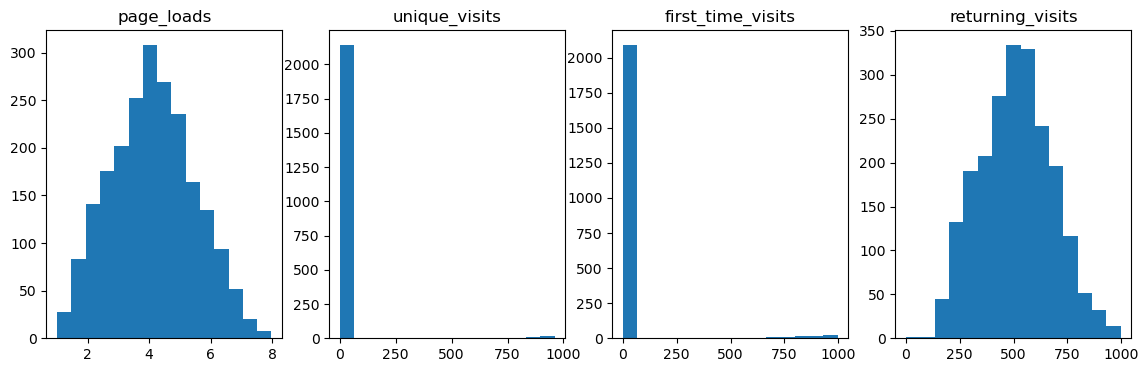

In [81]:
vizuelizacija(data,['page_loads','unique_visits','first_time_visits','returning_visits'],True)

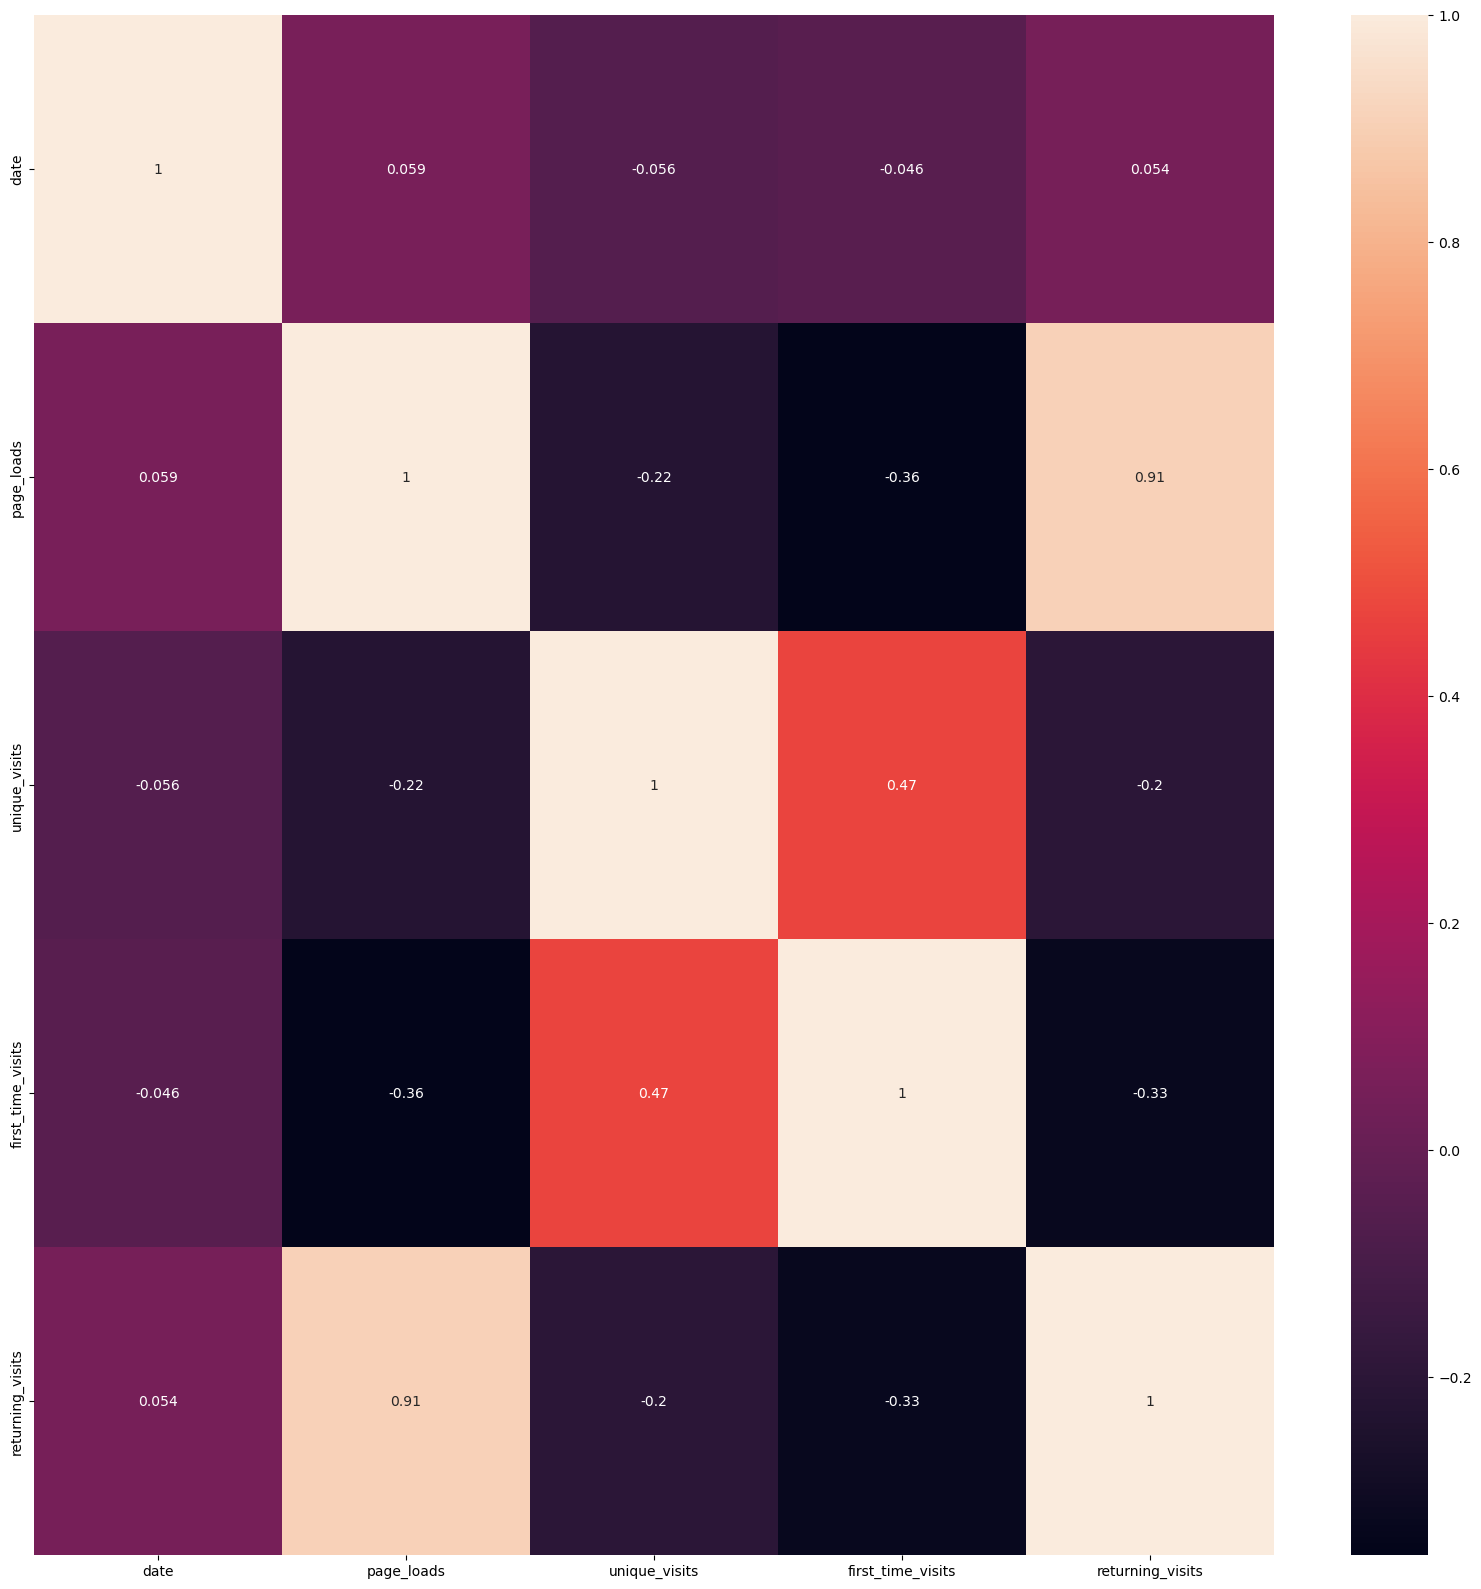

In [85]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True)
plt.show()

Encode the categorical features.

In [83]:
#ja dropnav, zatoa ne enkodirame

In [87]:
data.drop('date',axis=1,inplace=True)
data.head(5)

,page_loads,unique_visits,first_time_visits,returning_visits
0,2.146,1.582,1.430,152.0
1,3.621,2.528,2.297,231.0
2,3.698,2.630,2.352,278.0
3,3.667,2.614,2.327,287.0
4,3.316,2.366,2.130,236.0


# Feauture Extraction
Apply a lag of one, two, and three days to each chosen feature (except `day_of_week`), creating a set of features representing the statistics from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [91]:
columns_for_lags = data.columns
for feature in columns_for_lags:
    for lag in range(1,4):
        data[f'{feature}_lag_{lag}']=data[feature].shift()

In [93]:
data=data.dropna()

In [95]:
data.head(5)

,page_loads,unique_visits,first_time_visits,returning_visits,page_loads_lag_1,page_loads_lag_2,page_loads_lag_3,unique_visits_lag_1,unique_visits_lag_2,unique_visits_lag_3,first_time_visits_lag_1,first_time_visits_lag_2,first_time_visits_lag_3,returning_visits_lag_1,returning_visits_lag_2,returning_visits_lag_3
1,3.621,2.528,2.297,231.0,2.146,2.146,2.146,1.582,1.582,1.582,1.430,1.430,1.430,152.0,152.0,152.0
2,3.698,2.630,2.352,278.0,3.621,3.621,3.621,2.528,2.528,2.528,2.297,2.297,2.297,231.0,231.0,231.0
3,3.667,2.614,2.327,287.0,3.698,3.698,3.698,2.630,2.630,2.630,2.352,2.352,2.352,278.0,278.0,278.0
4,3.316,2.366,2.130,236.0,3.667,3.667,3.667,2.614,2.614,2.614,2.327,2.327,2.327,287.0,287.0,287.0
5,2.815,1.863,1.622,241.0,3.316,3.316,3.316,2.366,2.366,2.366,2.130,2.130,2.130,236.0,236.0,236.0


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [99]:
from sklearn.model_selection import train_test_split
data_new = data.drop('page_loads',axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(data_new,data['page_loads'],test_size=0.2,shuffle=False)

In [101]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

In [103]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [107]:
X_train = X_train.reshape(X_train.shape[0], lag, (X_train.shape[1] // lag))
X_test = X_test.reshape(X_test.shape[0], lag, (X_test.shape[1] // lag))

In [109]:
X_train.shape[1]

3

In [111]:
model = Sequential([
    Input((X_train.shape[1], X_train.shape[2],)),
    LSTM(8, activation="relu", return_sequences=True),
    LSTM(4, activation="relu"),
    Dense(1, activation="linear")
])

In [113]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [117]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=4, batch_size=8, shuffle=False)

Epoch 1/4
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 16.2164 - mean_squared_error: 16.2164 - val_loss: 1.2745 - val_mean_squared_error: 1.2745
Epoch 2/4
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5833 - mean_squared_error: 1.5833 - val_loss: 0.8259 - val_mean_squared_error: 0.8259
Epoch 3/4
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0196 - mean_squared_error: 1.0196 - val_loss: 0.5791 - val_mean_squared_error: 0.5791
Epoch 4/4
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7131 - mean_squared_error: 0.7131 - val_loss: 0.4402 - val_mean_squared_error: 0.4402


<Axes: >

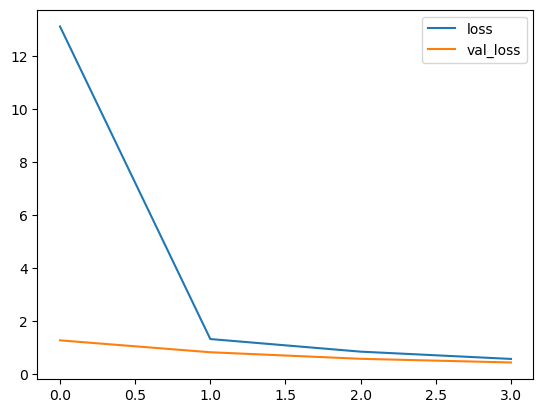

In [119]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [121]:
y_pred = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [127]:
y_pred = scaler.inverse_transform(y_pred)

ValueError: non-broadcastable output operand with shape (434,1) doesn't match the broadcast shape (434,15)

In [125]:
from sklearn.metrics import r2_score
r2_score(Y_test,y_pred)

0.7185173272974272

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

Use the trained model to make predictions for the test set.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

Use the trained model to make predictions for the test set.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [ ]:
# Write your code here. Add as many boxes as you need.

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [ ]:
# Write your code here. Add as many boxes as you need.